# Introduction to REML Analysis
Restricted Maximum Likelihood (REML) analysis is a statistical method used to estimate variance components in mixed models. This notebook provides a beginner-friendly guide to REML analysis, including data parsing, meta-analysis, heritability calculations, and visualizations. By the end of this notebook, you will understand how to analyze REML results and interpret key findings.

# Import Required Libraries
To get started, we need to import the necessary Python libraries. These libraries will help us handle data, perform statistical calculations, and create visualizations.

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid")
from tqdm import tqdm
import re
from scipy import stats
from matplotlib_venn import venn3, venn3_circles

# Load and Parse REML Results
REML results are typically stored in `.hsq` files. We will use the `parse_reml_results` function to load these files and parse them into a structured DataFrame for further analysis.

In [15]:
def parse_reml_results(res_files: list):
    res_dfs = []
    for res_file in res_files:
        fn = res_file.split("/")[-1]
        res = {}
        df = pd.read_csv(res_file, sep="\t")
        V_cols = [c for c in df["Source"].to_list() if c.startswith("V(") and "/Vp" not in c]
        for V_col in V_cols:
            Var = df.loc[df["Source"] == V_col, "Variance"].values[0]
            Var_se = df.loc[df["Source"] == V_col, "SE"].values[0]
            res[f"{V_col}"] = Var
            res[f"{V_col}_se"] = Var_se
        
        res["GRM_type"] = fn.split(".")[-2]
        res["sample_idx"] = fn.split(".")[-3].split("_")[-1]
        res["fn"] = fn
        res_dfs.append(pd.DataFrame(res, index=[0]))
    
    return pd.concat(res_dfs, ignore_index=True)

# Perform Meta-Analysis
Meta-analysis combines results from multiple studies to derive a pooled estimate. The `ivw_meta_analysis_general` function performs an Inverse Variance Weighted (IVW) meta-analysis on REML results.

In [16]:
def ivw_meta_analysis_general(df, group_by_col=None):
    """
    Perform IVW meta-analysis for variance components.
    
    Parameters:
    df: DataFrame containing REML results.
    group_by_col: Column name to group data by (e.g., 'GRM_type').
    
    Returns:
    DataFrame with meta-analysis results.
    """
    v_cols = [c for c in df.columns if c.startswith("V(") and "/Vp" not in c and "_se" not in c]
    
    def ivw_single(estimates, se_values):
        estimates = np.array(estimates)
        se_values = np.array(se_values)
        weights = 1 / (se_values ** 2)
        pooled_estimate = np.sum(weights * estimates) / np.sum(weights)
        pooled_se = np.sqrt(1 / np.sum(weights))
        return pooled_estimate, pooled_se
    
    results = []
    groups = df[group_by_col].unique() if group_by_col else ['All']
    
    for group in groups:
        subset = df[df[group_by_col] == group] if group_by_col else df
        result_row = {group_by_col: group} if group_by_col else {'Group': group}
        result_row['n_studies'] = len(subset)
        
        for v_col in v_cols:
            se_col = f"{v_col}_se"
            if se_col in df.columns:
                estimates = subset[v_col].values
                se_values = subset[se_col].values
                mask = ~(np.isnan(estimates) | np.isnan(se_values))
                if mask.sum() > 0:
                    ivw_est, ivw_se = ivw_single(estimates[mask], se_values[mask])
                    result_row[f"{v_col}"] = ivw_est
                    result_row[f"{v_col}_se"] = ivw_se
                else:
                    result_row[f"{v_col}"] = np.nan
                    result_row[f"{v_col}_se"] = np.nan
        results.append(result_row)
    
    return pd.DataFrame(results)

# Adjust Covariance for Specific Models
In some cases, covariance values need to be adjusted for specific models. The `div_cov_by_2` function demonstrates how to make such adjustments.

In [17]:
def div_cov_by_2(df_ivw):
    df = df_ivw.copy()
    df.loc[df["GRM_type"] == "FACTOR", "V(G2)"] = df.loc[df["GRM_type"] == "FACTOR", "V(G2)"] / 2
    df.loc[df["GRM_type"] == "FACTOR", "V(G2)_se"] = df.loc[df["GRM_type"] == "FACTOR", "V(G2)_se"] / 2
    return df

# Calculate Heritability for AD Model
Heritability in the AD model includes additive and dominance components. The `calculate_h2_AD` function computes these components along with their standard errors.

In [18]:
def calculate_h2_AD(df_res):
    df_ad = df_res.loc[df_res["GRM_type"] == "AD"].copy()
    V_add = df_ad["V(G1)"].values
    V_dom = df_ad["V(G2)"].values
    V_e = df_ad["V(e)"].values
    SE_add = df_ad["V(G1)_se"].values
    SE_dom = df_ad["V(G2)_se"].values
    SE_e = df_ad["V(e)_se"].values
    V_G = V_add + V_dom
    V_p = V_add + V_dom + V_e
    h2_add = V_add / V_p
    h2_dom = V_dom / V_p
    h2_AD = h2_add + h2_dom
    dh2add_dVadd = (V_dom + V_e) / (V_p**2)
    dh2add_dVdom = -V_add / (V_p**2)
    dh2add_dVe = -V_add / (V_p**2)
    SE_h2_add = np.sqrt(
        (dh2add_dVadd**2) * (SE_add**2) +
        (dh2add_dVdom**2) * (SE_dom**2) +
        (dh2add_dVe**2) * (SE_e**2)
    )
    dh2dom_dVadd = -V_dom / (V_p**2)
    dh2dom_dVdom = (V_add + V_e) / (V_p**2)
    dh2dom_dVe = -V_dom / (V_p**2)
    SE_h2_dom = np.sqrt(
        (dh2dom_dVadd**2) * (SE_add**2) +
        (dh2dom_dVdom**2) * (SE_dom**2) +
        (dh2dom_dVe**2) * (SE_e**2)
    )
    dh2AD_dVadd = V_e / (V_p**2)
    dh2AD_dVdom = V_e / (V_p**2)
    dh2AD_dVe = -V_G / (V_p**2)
    SE_h2_AD = np.sqrt(
        (dh2AD_dVadd**2) * (SE_add**2) +
        (dh2AD_dVdom**2) * (SE_dom**2) +
        (dh2AD_dVe**2) * (SE_e**2)
    )
    df_ad["h2(add)"] = h2_add
    df_ad["h2(dom)"] = h2_dom
    df_ad["h2(AD)"] = h2_AD
    df_ad["h2(add)_se"] = SE_h2_add
    df_ad["h2(dom)_se"] = SE_h2_dom
    df_ad["h2(AD)_se"] = SE_h2_AD
    return df_ad[["pheno", 
                  "h2(add)", "h2(add)_se", 
                  "h2(dom)", "h2(dom)_se", 
                  "h2(AD)", "h2(AD)_se"]]

# Calculate Heritability for FACTOR Model
The FACTOR model includes heterozygote and homozygote components. The `calculate_h2_FACTOR` function computes these components along with their standard errors.

In [ ]:
def calculate_h2_FACTOR(df_res):
    df_factor = df_res.loc[df_res["GRM_type"] == "FACTOR"].copy()
    # remove phenotypes with negative variance components
    neg_var_phenos = df_factor[(df_factor["V(G1)"] * df_factor["V(G3)"]) < 0]["pheno"].to_list()
    df_factor = df_factor[~df_factor["pheno"].isin(neg_var_phenos)]
    print(f"Removed {len(neg_var_phenos)} phenotypes with negative variance components")
    print(f"""
          ================
          {neg_var_phenos}
          """)
    
    # Variance components
    V_het = df_factor["V(G1)"].values  # heterozygote variance
    V_cross = df_factor["V(G2)"].values  # hetero X homo covariance
    V_hom = df_factor["V(G3)"].values  # homozygote variance
    V_e = df_factor["V(e)"].values  # error variance
    
    # Standard errors
    SE_het = df_factor["V(G1)_se"].values
    SE_cross = df_factor["V(G2)_se"].values
    SE_hom = df_factor["V(G3)_se"].values
    SE_e = df_factor["V(e)_se"].values
    
    # Total phenotypic variance
    V_p = V_het + V_hom + V_e
    V_G = V_het + V_hom
    
    # Calculate estimates
    Cov_hh = V_cross / np.sqrt(V_het * V_hom)  # Genetic correlation
    h2_het = V_het / V_p  # Heterozygote heritability
    h2_hom = V_hom / V_p  # Homozygote heritability
    hom_het_ratio = h2_hom / h2_het  # Ratio
    h2_FACTOR = h2_het + h2_hom  # Total heritability
    
    # ===== Delta Method Calculations =====
    
    # 1. Standard Error for Cov = V(G2) / sqrt(V(G1) * V(G3))
    sqrt_V1V3 = np.sqrt(V_het * V_hom)
    dCov_dV1 = -V_cross / (2 * V_het**(3/2) * V_hom**(1/2))
    dCov_dV2 = 1 / sqrt_V1V3
    dCov_dV3 = -V_cross / (2 * V_het**(1/2) * V_hom**(3/2))
    
    SE_VGG = np.sqrt(
        (dCov_dV1**2) * (SE_het**2) +
        (dCov_dV2**2) * (SE_cross**2) +
        (dCov_dV3**2) * (SE_hom**2)
    )
    
    # 2. Standard Error for h2(het) = V(G1) / V_p
    dh2het_dV1 = (V_hom + V_e) / (V_p**2)
    dh2het_dV3 = -V_het / (V_p**2)
    dh2het_dVe = -V_het / (V_p**2)
    
    SE_h2_het = np.sqrt(
        (dh2het_dV1**2) * (SE_het**2) +
        (dh2het_dV3**2) * (SE_hom**2) +
        (dh2het_dVe**2) * (SE_e**2)
    )
    
    # 3. Standard Error for h2(hom) = V(G3) / V_p
    dh2hom_dV1 = -V_hom / (V_p**2)
    dh2hom_dV3 = (V_het + V_e) / (V_p**2)
    dh2hom_dVe = -V_hom / (V_p**2)
    
    SE_h2_hom = np.sqrt(
        (dh2hom_dV1**2) * (SE_het**2) +
        (dh2hom_dV3**2) * (SE_hom**2) +
        (dh2hom_dVe**2) * (SE_e**2)
    )
    
    # 4. Standard Error for hom/het ratio = V(G3) / V(G1)
    dratio_dV1 = -V_hom / (V_het**2)
    dratio_dV3 = 1 / V_het
    
    SE_hom_het_ratio = np.sqrt(
        (dratio_dV1**2) * (SE_het**2) +
        (dratio_dV3**2) * (SE_hom**2)
    )
    
    # 5. Standard Error for h2(FACTOR) = h2(het) + h2(hom)
    dh2factor_dV1 = V_e / (V_p**2)
    dh2factor_dV3 = V_e / (V_p**2)
    dh2factor_dVe = -V_G / (V_p**2)
    
    SE_h2_FACTOR = np.sqrt(
        (dh2factor_dV1**2) * (SE_het**2) +
        (dh2factor_dV3**2) * (SE_hom**2) +
        (dh2factor_dVe**2) * (SE_e**2)
    )
    
    # Add results to dataframe
    df_factor["Cov(hh)"] = Cov_hh
    df_factor["Cov(hh)_se"] = SE_VGG
    df_factor["h2(het)"] = h2_het
    df_factor["h2(het)_se"] = SE_h2_het
    df_factor["h2(hom)"] = h2_hom
    df_factor["h2(hom)_se"] = SE_h2_hom
    df_factor["hom/het"] = hom_het_ratio
    df_factor["hom/het_se"] = SE_hom_het_ratio
    df_factor["h2(FACTOR)"] = h2_FACTOR
    df_factor["h2(FACTOR)_se"] = SE_h2_FACTOR
    
    return df_factor[["pheno", 
                      "h2(het)", "h2(het)_se", 
                      "h2(hom)", "h2(hom)_se",
                      "Cov(hh)", "Cov(hh)_se",
                      "hom/het", "hom/het_se",
                      "h2(FACTOR)", "h2(FACTOR)_se"]]
    
def add_significance_test_factor(df_factor, return_all_cols=False):
    """
    Add significance tests for FACTOR model estimates
    - h2: one-tailed test (H0: h2 <= 0, H1: h2 > 0)
    - Cov(hh): two-tailed test (H0: correlation = 1, H1: correlation ≠ 1)
    - hom/het: two-tailed test (H0: ratio = 4, H1: ratio ≠ 4)
    """
    df_result = df_factor.copy()
    cols = df_result.columns.to_list()
    
    # Calculate z-statistics for heritabilities (one-tailed test: h2 > 0)
    df_result["h2(het)_z"] = df_result["h2(het)"] / df_result["h2(het)_se"]
    df_result["h2(hom)_z"] = df_result["h2(hom)"] / df_result["h2(hom)_se"]
    df_result["h2(FACTOR)_z"] = df_result["h2(FACTOR)"] / df_result["h2(FACTOR)_se"]
    
    # Calculate z-statistics for Cov(hh) (two-tailed test: correlation ≠ 1)
    df_result["Cov(hh)_z"] = (df_result["Cov(hh)"] - 1) / df_result["Cov(hh)_se"]
    
    # Calculate z-statistics for hom/het ratio (two-tailed test: ratio ≠ 4)
    df_result["hom/het_z"] = (df_result["hom/het"] - 4) / df_result["hom/het_se"]
    
    # Calculate p-values
    # Two-tailed for heritabilities (H0: h2 = 0, H1: h2 ≠ 0)
    df_result["h2(het)_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["h2(het)_z"])))
    df_result["h2(hom)_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["h2(hom)_z"])))
    df_result["h2(FACTOR)_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["h2(FACTOR)_z"])))
    
    # Two-tailed for Cov(hh) (H0: correlation = 1) and hom/het ratio (H0: ratio = 4)
    df_result["Cov(hh)_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["Cov(hh)_z"])))
    df_result["hom/het_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["hom/het_z"])))
    
    # # One-tailed for heritabilities (H0: h2 <= 0)
    # df_result["h2(het)_pval"] = 1 - stats.norm.cdf(df_result["h2(het)_z"])
    # df_result["h2(hom)_pval"] = 1 - stats.norm.cdf(df_result["h2(hom)_z"])
    # df_result["h2(FACTOR)_pval"] = 1 - stats.norm.cdf(df_result["h2(FACTOR)_z"])
    
    # # Two-tailed for Cov(hh) (H0: correlation = 1) and hom/het ratio (H0: ratio = 4)
    # df_result["Cov(hh)_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["Cov(hh)_z"])))
    # df_result["hom/het_pval"] = 2 * (1 - stats.norm.cdf(np.abs(df_result["hom/het_z"])))
    
    # Determine significance (p < 0.05)
    df_result["h2(het)_sig"] = df_result["h2(het)_pval"] < 0.05
    df_result["h2(hom)_sig"] = df_result["h2(hom)_pval"] < 0.05
    df_result["h2(FACTOR)_sig"] = df_result["h2(FACTOR)_pval"] < 0.05
    df_result["Cov(hh)_sig"] = df_result["Cov(hh)_pval"] < 0.05
    df_result["hom/het_sig"] = df_result["hom/het_pval"] < 0.05
    
    if return_all_cols:
        return df_result
    else:
        return df_result[cols + ["h2(het)_sig", "h2(hom)_sig", "h2(FACTOR)_sig", 
                                "Cov(hh)_sig", "hom/het_sig"]]


# Load dataframe

In [19]:
df = pd.read_csv(
    "../../data/meta.tsv",
    sep="\t",   
)

df

,pheno,h2(add),h2(add)_se,h2(dom),h2(dom)_se,h2(AD),h2(AD)_se,h2(add)_sig,h2(dom)_sig,h2(AD)_sig,...,Cov(hh)_se,hom/het,hom/het_se,h2(FACTOR),h2(FACTOR)_se,h2(het)_sig,h2(hom)_sig,h2(FACTOR)_sig,Cov(hh)_sig,hom/het_sig
0,Leg_predicted_mass__left_,0.223203,0.010447,-0.012316,0.012577,0.210887,0.014094,True,False,True,...,0.070014,2.669175,0.543624,0.275881,0.018004,True,True,True,True,True
1,Leg_fat-free_mass__right_,0.234000,0.010457,-0.042064,0.012545,0.191936,0.014130,True,True,True,...,0.059279,2.721124,0.493128,0.300300,0.016716,True,True,True,True,True
2,Whole_body_fat-free_mass,0.249541,0.010251,0.003164,0.012478,0.252705,0.013515,True,False,True,...,0.042341,2.529671,0.433933,0.310325,0.016830,True,True,True,True,True
3,Mean_corpuscular_volume,0.258349,0.011320,-0.077721,0.013550,0.180628,0.015162,True,True,True,...,0.041042,1.415681,0.206408,0.316388,0.016949,True,True,True,True,True
4,SHBG,0.157856,0.012201,-0.055996,0.014490,0.101860,0.017529,True,True,True,...,0.061597,2.156160,0.649853,0.195965,0.022430,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Whole_body_fat_mass,0.216574,0.011458,-0.131104,0.010371,0.085471,0.014702,True,True,True,...,0.075300,1.819720,0.386431,0.234845,0.019206,True,True,True,True,True
96,Platelet_count,0.252102,0.010619,-0.040868,0.012639,0.211234,0.014070,True,True,True,...,0.059010,1.831822,0.306671,0.299406,0.018069,True,True,True,True,True
97,Monocyte_count,0.218046,0.011536,-0.161739,0.012961,0.056307,0.016196,True,True,True,...,0.065792,2.339816,0.509871,0.236881,0.018237,True,True,True,True,True
98,Impedance_of_leg__right_,0.228167,0.010166,0.001957,0.012340,0.230124,0.013633,True,False,True,...,0.043388,1.874446,0.312539,0.285871,0.017192,True,True,True,True,True


# Visualization

In [28]:
# Venn diagram and heritability plot code 
import matplotlib.pyplot as plt
import numpy as np

def plot_heritability(df, h2_col, se_col, title, ylabel, figsize=(10, 6)):
    """
    Plot heritability estimates with error bars.
    
    Parameters:
    df: DataFrame containing heritability data.
    h2_col: Column name for heritability estimates.
    se_col: Column name for standard errors.
    title: Title of the plot.
    ylabel: Label for the y-axis.
    figsize: Size of the figure.
    """
    df_sorted = df.sort_values(h2_col, ascending=False)
    x_pos = np.arange(len(df_sorted))
    
    plt.figure(figsize=figsize)
    plt.errorbar(
        x_pos, df_sorted[h2_col], 
        yerr=1.96 * df_sorted[se_col], 
        fmt='o', color='blue', capsize=3, label='Heritability'
    )
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Line')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Phenotypes (sorted)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks([], [])  # Hide x-axis labels for simplicity
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_venn(set1, set2, set3, labels, title):
    """
    Create a simple Venn diagram for three sets.
    
    Parameters:
    set1, set2, set3: Sets to visualize.
    labels: Tuple of labels for the sets.
    title: Title of the plot.
    """
    from matplotlib_venn import venn3
    
    plt.figure(figsize=(8, 6))
    venn = venn3([set1, set2, set3], set_labels=labels)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Visualize AD Model Results
Visualization helps in understanding the significance of heritability estimates. Below, we create a Venn diagram and heritability plot for the AD model.

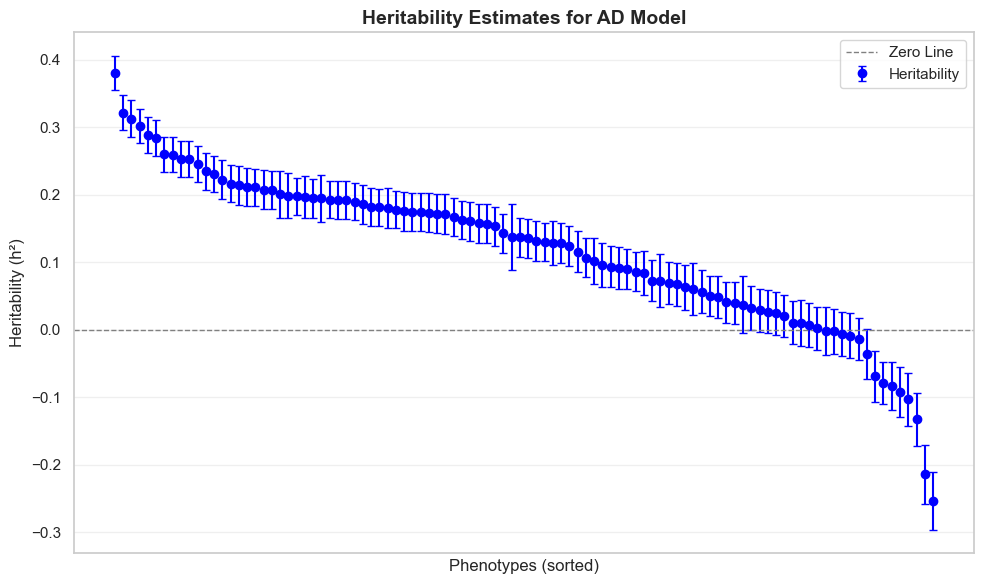

In [29]:
plot_heritability(
    df=df,
    h2_col="h2(AD)",
    se_col="h2(AD)_se",
    title="Heritability Estimates for AD Model",
    ylabel="Heritability (h²)"
)

/Users/jerry/miniconda/envs/factor/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


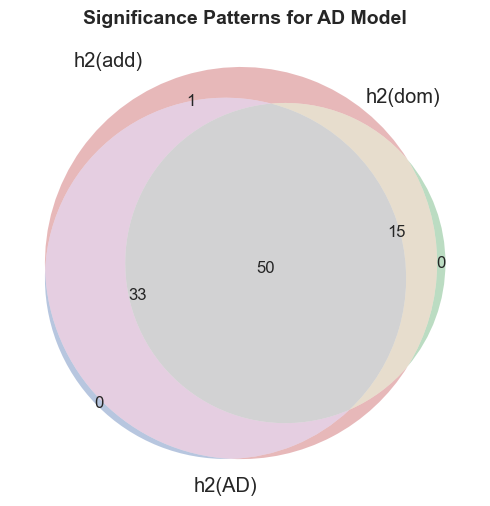

In [30]:
plot_venn(
    set1=set(df[df["h2(add)_sig"]].index),
    set2=set(df[df["h2(dom)_sig"]].index),
    set3=set(df[df["h2(AD)_sig"]].index),
    labels=("h2(add)", "h2(dom)", "h2(AD)"),
    title="Significance Patterns for AD Model"
)

# Visualize FACTOR Model Results
We generate visualizations for the FACTOR model, including a Venn diagram and heritability plot.

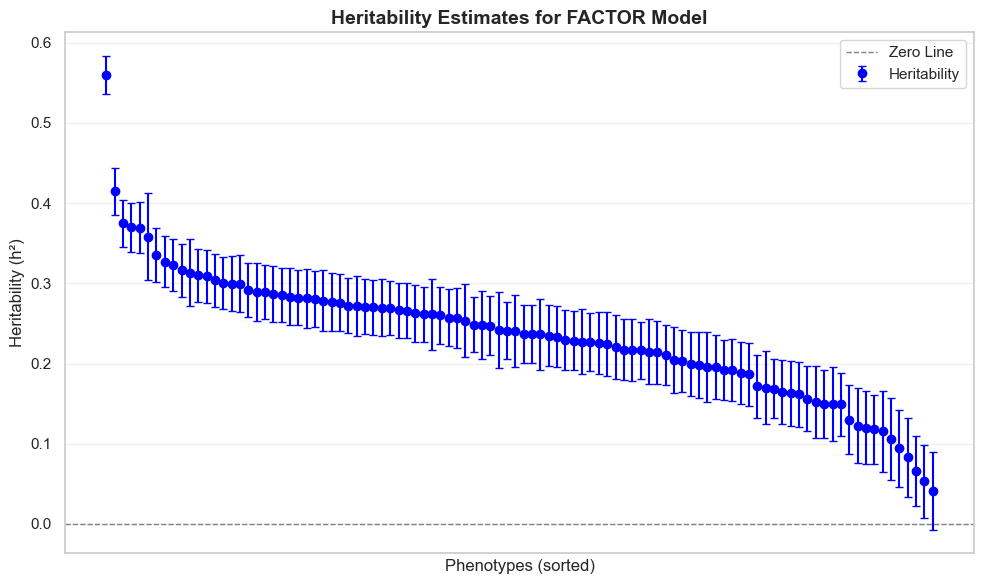

In [31]:
plot_heritability(
    df=df,
    h2_col="h2(FACTOR)",
    se_col="h2(FACTOR)_se",
    title="Heritability Estimates for FACTOR Model",
    ylabel="Heritability (h²)"
)

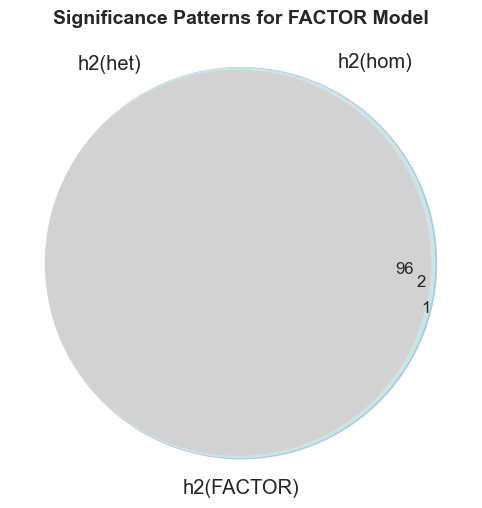

In [32]:
plot_venn(
    set1=set(df[df["h2(het)_sig"]].index),
    set2=set(df[df["h2(hom)_sig"]].index),
    set3=set(df[df["h2(FACTOR)_sig"]].index),
    labels=("h2(het)", "h2(hom)", "h2(FACTOR)"),
    title="Significance Patterns for FACTOR Model"
)

# Analyze Covariance Between Heterozygote and Homozygote Effects
Finally, we analyze and visualize the covariance between heterozygote and homozygote effects using the `plot_covariance_analysis` function.

In [33]:
def plot_covariance_analysis(df, cov_col, se_col, title, ylabel, figsize=(10, 6)):
    """
    Plot covariance estimates with error bars.
    
    Parameters:
    df: DataFrame containing covariance data.
    cov_col: Column name for covariance estimates.
    se_col: Column name for standard errors.
    title: Title of the plot.
    ylabel: Label for the y-axis.
    figsize: Size of the figure.
    """
    df_sorted = df.sort_values(cov_col, ascending=False)
    x_pos = np.arange(len(df_sorted))
    
    plt.figure(figsize=figsize)
    plt.errorbar(
        x_pos, df_sorted[cov_col], 
        yerr=1.96 * df_sorted[se_col], 
        fmt='o', color='green', capsize=3, label='Covariance'
    )
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Line')
    plt.axhline(y=1, color='blue', linestyle='--', linewidth=1, label='Perfect Correlation (1)')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='Perfect Anti-Correlation (-1)')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Phenotypes (sorted)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks([], [])  # Hide x-axis labels for simplicity
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

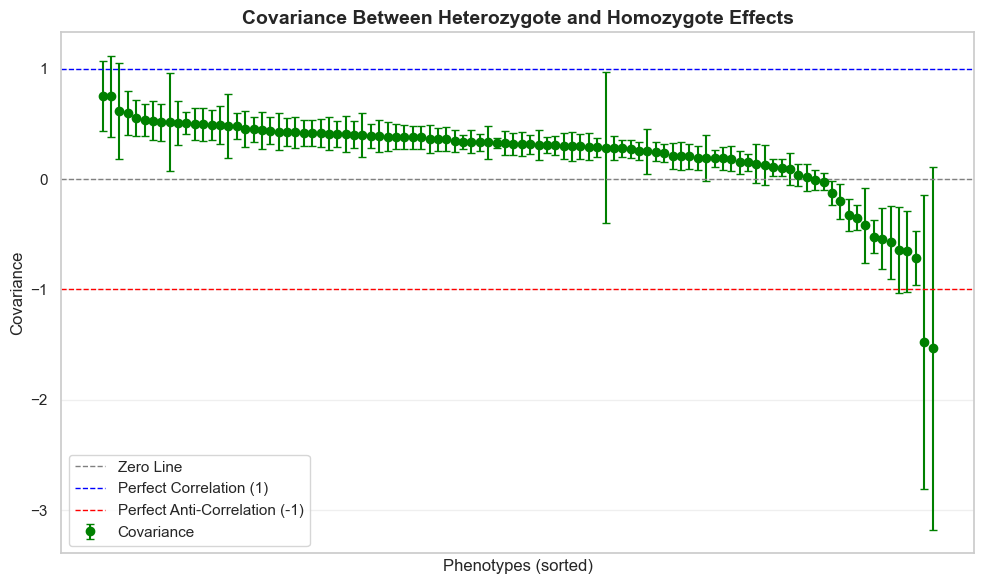

In [34]:
plot_covariance_analysis(
    df=df,
    cov_col="Cov(hh)",
    se_col="Cov(hh)_se",
    title="Covariance Between Heterozygote and Homozygote Effects",
    ylabel="Covariance"
)